In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import BondGraphTools as bgt
import julia

# The cardiac Na+/K+ ATPase Bond Graph Model

In [21]:
# Reaction Conductance in fmol/s
reactions = [ #reactants_tuple, products_tuple, rate
    (("P1",),("Ki","P2"), 330.5462), 
    (("P2",), ("Ki","P3",), 132850.9145),
    (("P3","Nai"), ("P4",), 200356.0223),
    (("P4","Nai"), ("P5",), 2238785.3951),
    (("P5","Nai"), ("P6", "zF_5"), 10787.9053),
    (("P6",), ("MgADP", "P7"), 15.3533),
    (("P7",),("P8",), 2.3882),
    (("P8",), ("P9", "Nae", "zF_8"), 2.2855),
    (("P9",), ("P10", "Nae"), 1540.1349),
    (("P10",),("P11","Nae"), 259461.6507),
    (("P11","Ke"), ("P12",), 172042.3334),
    (("P12","Ke"), ("P13",), 6646440.3909),
    (("P13",), ("P_i","H","P14"), 597.4136),
    (("P14","MgATP"),("P15",), 709823),
    (("P15",),("P1",), 0.015489)
]
     
# Chemical Affinities in 1/fmol
pump_affinities = [101619537.2009,
                  63209.8623,
                  157.2724,
                  14.0748,
                  5.0384,
                  92.6964,
                  4854.5924,
                  15260.9786,
                  13787022.8009,
                  20459.5509,
                  121.4556,
                  3.1436,
                  0.32549,
                  156.3283,
                  1977546.8577]
species_affinities = {
    "Ki":0.0012595,#intracellular potassium
    "Ke":0.009236, #extracelluar potassium
    "Nai":0.00083514,  #intracellular sodium
    "Nae":0.0061242,   #extracelluar sodium
    "MgATP": 2.3715,
    "MgADP": 7.976*10**-5,
    "P_i": 0.04565,
    "H": 0.04565
}
membrane_capacitance = 153400 #fentoFarad ?
r5_charge = -0.0550
r8_charge = -0.9450
Gas_Constant =  8.3144621
Temperature = 310

In [22]:
model = bgt.new(name="ATPase")
# add all the pumps
for pump, affinity in enumerate(pump_affinities):
    parameters = {'k':affinity,
                  'R':Gas_Constant,
                  'T':Temperature}
    name = "P{}".format(pump+1)
    Ce = bgt.new(component="Ce",
                 name=name,
                 library="BioChem",
                 value=parameters)
    junction = bgt.new("0", name=name)

    model.add(Ce, junction)
    model.connect(Ce, junction)

In [23]:
# add all the species
for species, affinity in species_affinities.items():
    parameters = {'k':affinity,
                  'R':Gas_Constant,
                  'T':Temperature}
    Ce = bgt.new(component="Ce",
                 name=species,
                 library="BioChem",
                 value=parameters)

    junction = bgt.new("0", name=species)
    model.add(Ce, junction)
    model.connect(Ce, junction)

In [24]:
#add the electrical components
c_mem = bgt.new('C',name="mem",value={'C':membrane_capacitance})
c_junction = bgt.new("0", name="mem")
model.add(c_mem, c_junction)
model.connect(c_mem, c_junction)

zF_5 = bgt.new('TF',name='zF_5', value={'r':r5_charge})
zF_8 = bgt.new('TF',name='zF_8', value={'r':r8_charge})

model.add(zF_5, zF_8)
port= 1 #  port 0 is the primary winding of a transformer and 1 is the secondary winding.
zF_5_secondary = (zF_5, port)  
zF_8_secondary = (zF_8, port) 
model.connect(zF_5_secondary, c_junction)
model.connect(zF_8_secondary, c_junction)

In [25]:
# add all the reactions and wire it up
for reaction_number, (reactants, products, rate) in enumerate(reactions):
    parameters  = {'r':rate, 'R':Gas_Constant, 'T':Temperature}
    name = "R{}".format(reaction_number+1)

    Re = bgt.new("Re", name=name, library="BioChem", value=parameters)
    model.add(Re)
    
    if len(reactants) > 1:
        in_port = bgt.new("Y", name=name+"_in",library="BioChem")
        model.add(in_port)
        model.connect((Re, 0), (in_port, 0))
        for reactant in reactants:
            junction = model.find(component="0", name=reactant)
            model.connect(junction, in_port)
    else:
        junction = model.find(component="0", name=reactants[0])
        model.connect((Re,0), junction)
        
    if len(products) > 1:
        out_port = bgt.new("Y", name=name+"_out",library="BioChem")
        model.add(out_port)
        model.connect((Re, 1), (out_port, 0))
        for product in products:
            if product == 'zF_5':
                junction = (zF_5, 0) # the primary winding of the charge transporter
            elif product == 'zF_8':
                junction = (zF_8, 0)
            else:
                junction = model.find(component="0", name=product)

            model.connect(junction, out_port)
    else:
        junction = model.find(component="0", name=products[0])
        model.connect((Re,1), junction)

In [26]:
# This may take some time on a slower computer as this involves computing all the necessary symbolic reductions
# For reference, it takes around 81s on my computer
import time
start = time.time()
model_equations = model.constitutive_relations
stop = time.time() - start

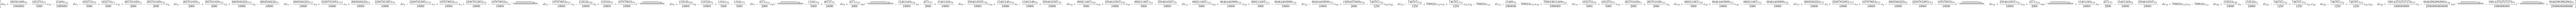

In [28]:
# There is a constant 'c' added in order to deal with integral relationships
import sympy as sp
sp.init_printing()
model_equations = [ e.subs(sp.symbols('c'),0) for e in model_equations]
model_equations

In [29]:
# or to generate the latex
print(sp.latex(model_equations))

\left [ dx_{0} + \frac{330561689 x_{0}}{1000000} - \frac{1652731 x_{1}}{5000} x_{15} - \frac{15489 x_{14}}{1000000}, \quad dx_{1} - \frac{1652731 x_{0}}{5000} + \frac{1652731 x_{1}}{5000} x_{15} + \frac{265701829 x_{1}}{2000} - \frac{265701829 x_{15}}{2000} x_{2}, \quad dx_{2} - \frac{265701829 x_{1}}{2000} + \frac{265701829 x_{15}}{2000} x_{2} + \frac{2003560223 x_{17}}{10000} x_{2} - \frac{2003560223 x_{3}}{10000}, \quad dx_{3} - \frac{2003560223 x_{17}}{10000} x_{2} + \frac{22387853951 x_{17}}{10000} x_{3} + \frac{2003560223 x_{3}}{10000} - \frac{22387853951 x_{4}}{10000}, \quad dx_{4} - \frac{22387853951 x_{17}}{10000} x_{3} + \frac{107879053 x_{17}}{10000} x_{4} + \frac{22387853951 x_{4}}{10000} - \frac{107879053 x_{5}}{10000} e^{- \frac{459849902839799 x_{23}}{10000000000000000000000}}, \quad dx_{5} - \frac{107879053 x_{17}}{10000} x_{4} - \frac{153533 x_{20}}{10000} x_{6} + \frac{153533 x_{5}}{10000} + \frac{107879053 x_{5}}{10000} e^{- \frac{459849902839799 x_{23}}{100000000000